In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-3  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.1


In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 144/144 [00:02<00:00, 68.49it/s]


In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [6]:
!nvidia-smi

Tue Dec 10 14:37:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   57C    P0             80W /  290W |    3408MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [8]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 0.826255 val loss: 0.784966
saving, val loss enhanced: 0.7849655174826342 10000
Epoch: 2 	Training Loss: 0.813557 val loss: 0.779196
saving, val loss enhanced: 0.7791958270698738 0.7849655174826342
Epoch: 3 	Training Loss: 0.810992 val loss: 0.766037
saving, val loss enhanced: 0.766037413397248 0.7791958270698738
Epoch: 4 	Training Loss: 0.796010 val loss: 0.756999
saving, val loss enhanced: 0.7569985494714376 0.766037413397248
Epoch: 5 	Training Loss: 0.780951 val loss: 0.733104
saving, val loss enhanced: 0.733103813935746 0.7569985494714376
Epoch: 6 	Training Loss: 0.782335 val loss: 0.732409
saving, val loss enhanced: 0.7324088954375598 0.733103813935746
Epoch: 7 	Training Loss: 0.764765 val loss: 0.726649
saving, val loss enhanced: 0.726649054809791 0.7324088954375598
Epoch: 8 	Training Loss: 0.759985 val loss: 0.718037
saving, val loss enhanced: 0.7180365588027718 0.726649054809791
Epoch: 9 	Training Loss: 0.749334 val loss: 0.702025
saving, val loss enhan

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4260.24iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4153.66iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.539121 val loss: 5.500989
saving, val loss enhanced: 5.500989251985745 1000000000000000.0
Epoch: 2 	Training Loss: 1.538395 val loss: 5.499576
saving, val loss enhanced: 5.499576476567124 5.500989251985745
Epoch: 3 	Training Loss: 1.537706 val loss: 5.498114
saving, val loss enhanced: 5.498114318192047 5.499576476567124
Epoch: 4 	Training Loss: 1.537022 val loss: 5.496634
saving, val loss enhanced: 5.496633923524773 5.498114318192047
Epoch 1 time: 4.45 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4307.06iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.544495 val loss: 5.476957
saving, val loss enhanced: 5.476956746754922 5.496633923524773
Epoch: 2 	Training Loss: 1.543810 val loss: 5.475471
saving, val loss enhanced: 5.475471152226872 5.476956746754922
Epoch: 3 	Training Loss: 1.543125 val loss: 5.473986
saving, val loss enhanced: 5.473985838943164 5.475471152226872
Epoch: 4 	Training Loss: 1.542441 val loss: 5.472501
saving, val loss enhanced: 5.472501279180674 5.473985838943164
Epoch 2 time: 4.29 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4326.87iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.552019 val loss: 5.447517
saving, val loss enhanced: 5.447516593685371 5.472501279180674
Epoch: 2 	Training Loss: 1.551331 val loss: 5.446043
saving, val loss enhanced: 5.446042954770365 5.447516593685371
Epoch: 3 	Training Loss: 1.550642 val loss: 5.444573
saving, val loss enhanced: 5.444572771785362 5.446042954770365
Epoch: 4 	Training Loss: 1.549953 val loss: 5.443105
saving, val loss enhanced: 5.4431051022877055 5.444572771785362
Epoch 3 time: 4.27 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4166.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.559744 val loss: 5.418304
saving, val loss enhanced: 5.418303941333663 5.4431051022877055
Epoch: 2 	Training Loss: 1.559050 val loss: 5.416848
saving, val loss enhanced: 5.4168483468900765 5.418303941333663
Epoch: 3 	Training Loss: 1.558356 val loss: 5.415396
saving, val loss enhanced: 5.415396356668709 5.4168483468900765
Epoch: 4 	Training Loss: 1.557661 val loss: 5.413947
saving, val loss enhanced: 5.413946850913568 5.415396356668709
Epoch 4 time: 4.34 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4251.58iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.567609 val loss: 5.389486
saving, val loss enhanced: 5.389486421394161 5.413946850913568
Epoch: 2 	Training Loss: 1.566909 val loss: 5.388048
saving, val loss enhanced: 5.388048419091498 5.389486421394161
Epoch: 3 	Training Loss: 1.566208 val loss: 5.386614
saving, val loss enhanced: 5.386613798798184 5.388048419091498
Epoch: 4 	Training Loss: 1.565508 val loss: 5.385181
saving, val loss enhanced: 5.385181442253741 5.386613798798184
Epoch 5 time: 4.31 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3949.65iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.575628 val loss: 5.361071
saving, val loss enhanced: 5.361070791705305 5.385181442253741
Epoch: 2 	Training Loss: 1.574922 val loss: 5.359649
saving, val loss enhanced: 5.359649260520509 5.361070791705305
Epoch: 3 	Training Loss: 1.574216 val loss: 5.358231
saving, val loss enhanced: 5.358230901811657 5.359649260520509
Epoch: 4 	Training Loss: 1.573509 val loss: 5.356815
saving, val loss enhanced: 5.3568146233814 5.358230901811657
Epoch 6 time: 4.47 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4212.21iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.583825 val loss: 5.333054
saving, val loss enhanced: 5.333054017561898 5.3568146233814
Epoch: 2 	Training Loss: 1.583113 val loss: 5.331648
saving, val loss enhanced: 5.33164798687315 5.333054017561898
Epoch: 3 	Training Loss: 1.582400 val loss: 5.330245
saving, val loss enhanced: 5.330244968319362 5.33164798687315
Epoch: 4 	Training Loss: 1.581688 val loss: 5.328844
saving, val loss enhanced: 5.32884389534048 5.330244968319362
Epoch 7 time: 4.30 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3931.03iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.592218 val loss: 5.305421
saving, val loss enhanced: 5.305420634716071 5.32884389534048
Epoch: 2 	Training Loss: 1.591500 val loss: 5.304029
saving, val loss enhanced: 5.304029326356988 5.305420634716071
Epoch: 3 	Training Loss: 1.590781 val loss: 5.302641
saving, val loss enhanced: 5.302640907089351 5.304029326356988
Epoch: 4 	Training Loss: 1.590062 val loss: 5.301254
saving, val loss enhanced: 5.3012543328281945 5.302640907089351
Epoch 8 time: 4.46 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4246.84iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.600825 val loss: 5.278171
saving, val loss enhanced: 5.2781711708721 5.3012543328281945
Epoch: 2 	Training Loss: 1.600100 val loss: 5.276794
saving, val loss enhanced: 5.276793937609212 5.2781711708721
Epoch: 3 	Training Loss: 1.599374 val loss: 5.275419
saving, val loss enhanced: 5.275419493997545 5.276793937609212
Epoch: 4 	Training Loss: 1.598649 val loss: 5.274047
saving, val loss enhanced: 5.274046816274457 5.275419493997545
Epoch 9 time: 4.23 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4014.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.609657 val loss: 5.251289
saving, val loss enhanced: 5.2512893937767595 5.274046816274457
Epoch: 2 	Training Loss: 1.608925 val loss: 5.249926
saving, val loss enhanced: 5.249925678382283 5.2512893937767595
Epoch: 3 	Training Loss: 1.608193 val loss: 5.248565
saving, val loss enhanced: 5.248564669280336 5.249925678382283
Epoch: 4 	Training Loss: 1.607461 val loss: 5.247205
saving, val loss enhanced: 5.247205361326234 5.248564669280336
Epoch 10 time: 4.38 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4121.56iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.618732 val loss: 5.224779
saving, val loss enhanced: 5.224778832871265 5.247205361326234
Epoch: 2 	Training Loss: 1.617993 val loss: 5.223428
saving, val loss enhanced: 5.22342813534492 5.224778832871265
Epoch: 3 	Training Loss: 1.617255 val loss: 5.222080
saving, val loss enhanced: 5.222080071207284 5.22342813534492
Epoch: 4 	Training Loss: 1.616516 val loss: 5.220734
saving, val loss enhanced: 5.220733652916322 5.222080071207284
Epoch 11 time: 4.37 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4143.38iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.628061 val loss: 5.198629
saving, val loss enhanced: 5.198629325621828 5.220733652916322
Epoch: 2 	Training Loss: 1.627316 val loss: 5.197291
saving, val loss enhanced: 5.1972911888237965 5.198629325621828
Epoch: 3 	Training Loss: 1.626571 val loss: 5.195956
saving, val loss enhanced: 5.195955620449531 5.1972911888237965
Epoch: 4 	Training Loss: 1.625825 val loss: 5.194622
saving, val loss enhanced: 5.194621649614316 5.195955620449531
Epoch 12 time: 4.31 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3852.75iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.637662 val loss: 5.172840
saving, val loss enhanced: 5.172840132811097 5.194621649614316
Epoch: 2 	Training Loss: 1.636910 val loss: 5.171514
saving, val loss enhanced: 5.171514129946256 5.172840132811097
Epoch: 3 	Training Loss: 1.636158 val loss: 5.170191
saving, val loss enhanced: 5.170190636302105 5.171514129946256
Epoch: 4 	Training Loss: 1.635405 val loss: 5.168869
saving, val loss enhanced: 5.168868696952001 5.170190636302105
Epoch 13 time: 4.80 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4216.12iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.647548 val loss: 5.147404
saving, val loss enhanced: 5.147404213478781 5.168868696952001
Epoch: 2 	Training Loss: 1.646789 val loss: 5.146090
saving, val loss enhanced: 5.146089943078876 5.147404213478781
Epoch: 3 	Training Loss: 1.646030 val loss: 5.144778
saving, val loss enhanced: 5.144778127546541 5.146089943078876
Epoch: 4 	Training Loss: 1.645270 val loss: 5.143468
saving, val loss enhanced: 5.143467827181235 5.144778127546541
Epoch 14 time: 4.36 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4215.71iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.657737 val loss: 5.122324
saving, val loss enhanced: 5.122323976126675 5.143467827181235
Epoch: 2 	Training Loss: 1.656971 val loss: 5.121021
saving, val loss enhanced: 5.121021055195196 5.122323976126675
Epoch: 3 	Training Loss: 1.656205 val loss: 5.119721
saving, val loss enhanced: 5.11972053843622 5.121021055195196
Epoch: 4 	Training Loss: 1.655438 val loss: 5.118422
saving, val loss enhanced: 5.118421500825167 5.11972053843622
Epoch 15 time: 4.30 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4267.82iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.668245 val loss: 5.097592
saving, val loss enhanced: 5.097592436716053 5.118421500825167
Epoch: 2 	Training Loss: 1.667471 val loss: 5.096300
saving, val loss enhanced: 5.096300499598737 5.097592436716053
Epoch: 3 	Training Loss: 1.666697 val loss: 5.095011
saving, val loss enhanced: 5.09501091930024 5.096300499598737
Epoch: 4 	Training Loss: 1.665924 val loss: 5.093723
saving, val loss enhanced: 5.093722784859613 5.09501091930024
Epoch 16 time: 4.26 seconds


In [9]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[9.99988794e-01 9.90066967e-01 8.08211435e-01 5.33725004e-01
 4.67928592e-01 2.34616281e-01 1.89820111e-01 1.84991409e-02
 3.01449320e-04 2.46480903e-06]


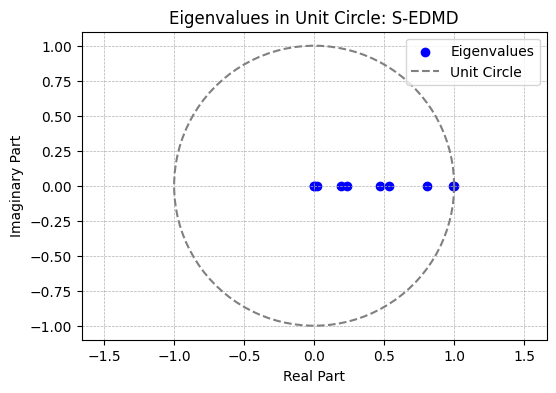

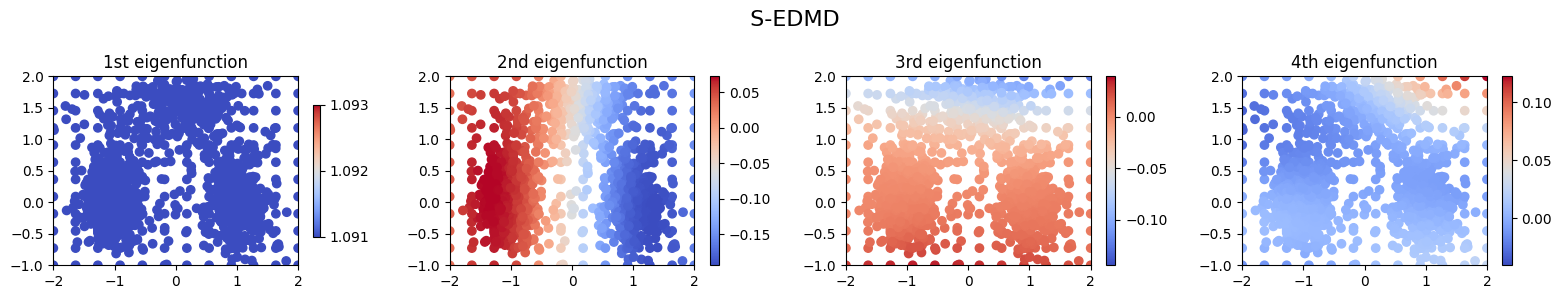

In [10]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4887.01iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4354.73iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4816.97iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4742.55iteration/s]


Epoch: 1 	Training Loss: 2.462772 val loss: 6.075989
saving, val loss enhanced: 6.075988549665868 1000000000000000.0
Epoch: 2 	Training Loss: 2.460560 val loss: 6.074641
saving, val loss enhanced: 6.074641266564179 6.075988549665868
Epoch: 3 	Training Loss: 2.458366 val loss: 6.073284
saving, val loss enhanced: 6.073284075401193 6.074641266564179
Epoch: 4 	Training Loss: 2.456175 val loss: 6.071924
saving, val loss enhanced: 6.071924088573605 6.073284075401193
Epoch 1 time: 9.77 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4622.84iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4734.16iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4900.24iteration/s]


Epoch: 1 	Training Loss: 2.449153 val loss: 6.067644
saving, val loss enhanced: 6.067643806102325 6.071924088573605
Epoch: 2 	Training Loss: 2.446976 val loss: 6.066288
saving, val loss enhanced: 6.066288135448089 6.067643806102325
Epoch: 3 	Training Loss: 2.444802 val loss: 6.064934
saving, val loss enhanced: 6.0649337004384565 6.066288135448089
Epoch: 4 	Training Loss: 2.442630 val loss: 6.063581
saving, val loss enhanced: 6.063580656784871 6.0649337004384565
Epoch 2 time: 9.56 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4901.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4811.97iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4538.10iteration/s]


Epoch: 1 	Training Loss: 2.435705 val loss: 6.059009
saving, val loss enhanced: 6.059009051089383 6.063580656784871
Epoch: 2 	Training Loss: 2.433547 val loss: 6.057663
saving, val loss enhanced: 6.057663486537348 6.059009051089383
Epoch: 3 	Training Loss: 2.431392 val loss: 6.056320
saving, val loss enhanced: 6.056319767145827 6.057663486537348
Epoch: 4 	Training Loss: 2.429240 val loss: 6.054978
saving, val loss enhanced: 6.054977729578823 6.056319767145827
Epoch 3 time: 9.56 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4744.83iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4772.67iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4695.28iteration/s]


Epoch: 1 	Training Loss: 2.422361 val loss: 6.050423
saving, val loss enhanced: 6.050422811664729 6.054977729578823
Epoch: 2 	Training Loss: 2.420223 val loss: 6.049088
saving, val loss enhanced: 6.049088462794877 6.050422811664729
Epoch: 3 	Training Loss: 2.418088 val loss: 6.047756
saving, val loss enhanced: 6.047755953402025 6.049088462794877
Epoch: 4 	Training Loss: 2.415957 val loss: 6.046425
saving, val loss enhanced: 6.046425066462132 6.047755953402025
Epoch 4 time: 9.53 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4766.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4394.73iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4679.51iteration/s]


Epoch: 1 	Training Loss: 2.409125 val loss: 6.041902
saving, val loss enhanced: 6.041901778036989 6.046425066462132
Epoch: 2 	Training Loss: 2.407007 val loss: 6.040578
saving, val loss enhanced: 6.040578430745041 6.041901778036989
Epoch: 3 	Training Loss: 2.404893 val loss: 6.039257
saving, val loss enhanced: 6.0392568477750705 6.040578430745041
Epoch: 4 	Training Loss: 2.402782 val loss: 6.037937
saving, val loss enhanced: 6.037936802103715 6.0392568477750705
Epoch 5 time: 9.82 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4597.99iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4681.01iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4788.81iteration/s]


Epoch: 1 	Training Loss: 2.395997 val loss: 6.033447
saving, val loss enhanced: 6.0334469523933425 6.037936802103715
Epoch: 2 	Training Loss: 2.393899 val loss: 6.032134
saving, val loss enhanced: 6.032134279882141 6.0334469523933425
Epoch: 3 	Training Loss: 2.391805 val loss: 6.030823
saving, val loss enhanced: 6.030823306139006 6.032134279882141
Epoch: 4 	Training Loss: 2.389714 val loss: 6.029514
saving, val loss enhanced: 6.0295138022292205 6.030823306139006
Epoch 6 time: 9.82 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4346.15iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4755.09iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4848.09iteration/s]


Epoch: 1 	Training Loss: 2.382974 val loss: 6.025058
saving, val loss enhanced: 6.025057530046131 6.0295138022292205
Epoch: 2 	Training Loss: 2.380897 val loss: 6.023755
saving, val loss enhanced: 6.023755259840313 6.025057530046131
Epoch: 3 	Training Loss: 2.378822 val loss: 6.022455
saving, val loss enhanced: 6.0224546379792345 6.023755259840313
Epoch: 4 	Training Loss: 2.376751 val loss: 6.021155
saving, val loss enhanced: 6.021155435029729 6.0224546379792345
Epoch 7 time: 9.97 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4529.06iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4491.95iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4428.21iteration/s]


Epoch: 1 	Training Loss: 2.370055 val loss: 6.016733
saving, val loss enhanced: 6.016732781395109 6.021155435029729
Epoch: 2 	Training Loss: 2.367998 val loss: 6.015441
saving, val loss enhanced: 6.01544069604237 6.016732781395109
Epoch: 3 	Training Loss: 2.365943 val loss: 6.014150
saving, val loss enhanced: 6.0141502193129694 6.01544069604237
Epoch: 4 	Training Loss: 2.363892 val loss: 6.012861
saving, val loss enhanced: 6.012861121603242 6.0141502193129694
Epoch 8 time: 9.87 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4816.84iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4324.83iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4679.37iteration/s]


Epoch: 1 	Training Loss: 2.357238 val loss: 6.008472
saving, val loss enhanced: 6.0084721811180275 6.012861121603242
Epoch: 2 	Training Loss: 2.355200 val loss: 6.007190
saving, val loss enhanced: 6.007190100797393 6.0084721811180275
Epoch: 3 	Training Loss: 2.353166 val loss: 6.005910
saving, val loss enhanced: 6.005909596257599 6.007190100797393
Epoch: 4 	Training Loss: 2.351134 val loss: 6.004630
saving, val loss enhanced: 6.004630437929115 6.005909596257599
Epoch 9 time: 9.76 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4657.76iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4659.32iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4888.89iteration/s]


Epoch: 1 	Training Loss: 2.344520 val loss: 6.000275
saving, val loss enhanced: 6.0002753051532505 6.004630437929115
Epoch: 2 	Training Loss: 2.342502 val loss: 5.999003
saving, val loss enhanced: 5.9990030747894965 6.0002753051532505
Epoch: 3 	Training Loss: 2.340487 val loss: 5.997732
saving, val loss enhanced: 5.997732391872617 5.9990030747894965
Epoch: 4 	Training Loss: 2.338475 val loss: 5.996463
saving, val loss enhanced: 5.996463027060981 5.997732391872617
Epoch 10 time: 9.64 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4766.67iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4617.84iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4770.68iteration/s]


Epoch: 1 	Training Loss: 2.331900 val loss: 5.992142
saving, val loss enhanced: 5.9921417319395145 5.996463027060981
Epoch: 2 	Training Loss: 2.329901 val loss: 5.990879
saving, val loss enhanced: 5.990879213358548 5.9921417319395145
Epoch: 3 	Training Loss: 2.327905 val loss: 5.989618
saving, val loss enhanced: 5.989618217001909 5.990879213358548
Epoch: 4 	Training Loss: 2.325912 val loss: 5.988359
saving, val loss enhanced: 5.988358513932442 5.989618217001909
Epoch 11 time: 9.65 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4804.23iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4867.26iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4799.36iteration/s]


Epoch: 1 	Training Loss: 2.319375 val loss: 5.984071
saving, val loss enhanced: 5.9840709700912615 5.988358513932442
Epoch: 2 	Training Loss: 2.317395 val loss: 5.982818
saving, val loss enhanced: 5.982818037318677 5.9840709700912615
Epoch: 3 	Training Loss: 2.315419 val loss: 5.981567
saving, val loss enhanced: 5.98156660381837 5.982818037318677
Epoch: 4 	Training Loss: 2.313445 val loss: 5.980316
saving, val loss enhanced: 5.980316441208983 5.98156660381837
Epoch 12 time: 9.48 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4647.84iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4915.26iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4848.45iteration/s]


Epoch: 1 	Training Loss: 2.306944 val loss: 5.976062
saving, val loss enhanced: 5.976062408353996 5.980316441208983
Epoch: 2 	Training Loss: 2.304983 val loss: 5.974819
saving, val loss enhanced: 5.974818944679198 5.976062408353996
Epoch: 3 	Training Loss: 2.303026 val loss: 5.973577
saving, val loss enhanced: 5.9735769590631556 5.974818944679198
Epoch: 4 	Training Loss: 2.301071 val loss: 5.972336
saving, val loss enhanced: 5.972336223806183 5.9735769590631556
Epoch 13 time: 9.53 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4765.04iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4844.36iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4730.93iteration/s]


Epoch: 1 	Training Loss: 2.294605 val loss: 5.968115
saving, val loss enhanced: 5.968115282333396 5.972336223806183
Epoch: 2 	Training Loss: 2.292663 val loss: 5.966881
saving, val loss enhanced: 5.9668811783514775 5.968115282333396
Epoch: 3 	Training Loss: 2.290724 val loss: 5.965649
saving, val loss enhanced: 5.965648532593852 5.9668811783514775
Epoch: 4 	Training Loss: 2.288788 val loss: 5.964417
saving, val loss enhanced: 5.964417118146871 5.965648532593852
Epoch 14 time: 9.53 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4594.97iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4538.52iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4824.91iteration/s]


Epoch: 1 	Training Loss: 2.282358 val loss: 5.960229
saving, val loss enhanced: 5.9602286563009 5.964417118146871
Epoch: 2 	Training Loss: 2.280434 val loss: 5.959004
saving, val loss enhanced: 5.959003808502187 5.9602286563009
Epoch: 3 	Training Loss: 2.278514 val loss: 5.957780
saving, val loss enhanced: 5.957780400210535 5.959003808502187
Epoch: 4 	Training Loss: 2.276596 val loss: 5.956558
saving, val loss enhanced: 5.956558205386175 5.957780400210535
Epoch 15 time: 9.86 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4653.08iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4796.47iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4777.80iteration/s]


Epoch: 1 	Training Loss: 2.270200 val loss: 5.952401
saving, val loss enhanced: 5.952401418245785 5.956558205386175
Epoch: 2 	Training Loss: 2.268295 val loss: 5.951186
saving, val loss enhanced: 5.951185727920388 5.952401418245785
Epoch: 3 	Training Loss: 2.266393 val loss: 5.949971
saving, val loss enhanced: 5.949971459296631 5.951185727920388
Epoch: 4 	Training Loss: 2.264493 val loss: 5.948758
saving, val loss enhanced: 5.948758387284798 5.949971459296631
Epoch 16 time: 9.64 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4758.20iteration/s]

dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[2.65402419+0.j         1.44630429+0.j         1.13596923+0.j
 1.        +0.j         0.99617271+0.j         0.87291712+0.j
 0.41176952-0.25887351j 0.41176952+0.25887351j 0.31739188+0.j
 0.08977011+0.j        ]


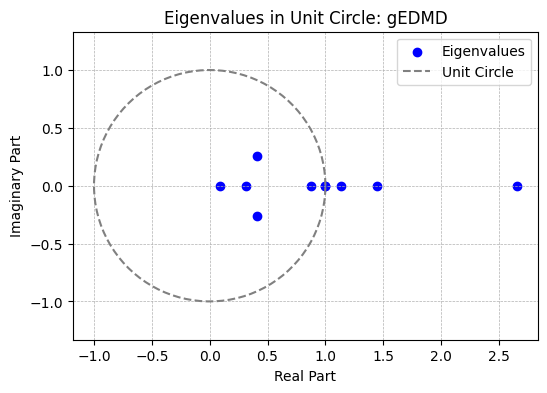

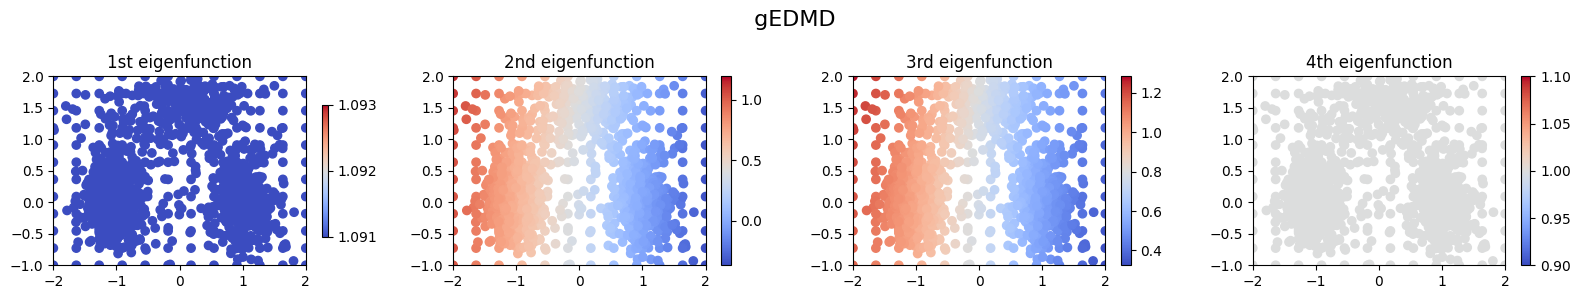

In [12]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
